# News Content NLP Analysis - Topic Modeling & Sentiment Analysis (Unsupervised Learning)

This is the python notebook of the news content natural language processing & machine learning project written by Huang Lin, Chun (Wally).

In this notebook, we exploited the dataset processed by the `1_fake_news_prediction.ipynb` in this project to conduct further analysis.

We analyzed the basic characteristics of this dataset, including the distribution of token counts and the Wordcloud (also, wordclouds condition on whether fake news or not.)

Furthermore, we conducted sentiment analysis based on the bag of word methodology in `nltk` module, and investigated whether sentiment index itself and its interaction with word count have correlation with target (fake news or not) through visualization. 

Finally, we utilized the `gensim` module to implement the unsupervised Latent Dirichlet Allocation (LDA) Topic Modeling. We chosse LDA rather than simple k-means clustering since LDA assigns documents with "probability" of the membership of topics, which could not be done by k-means, and which provides more flexibility. We determined the number of clusters (topics) to 10, and combined the topic clustering with wordcloud to better interpret the topics. 

- Data source: https://www.kaggle.com/datasets/saurabhshahane/fake-news-classification
- Number of unique rows: 62348
- News contents are from american press media.
- Row data and processed data are not available in this repository due to the tremendous size.
- Whole dataset was used in this dataset.

### Import Module & Data

In [1]:
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np 
import re

from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors
import seaborn as sns

from wordcloud import WordCloud
import time

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
import string

import gensim
from gensim import corpora
import ast
import pickle

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/huanglinchun/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
data = pd.read_csv('tokenized_data.csv').drop('Unnamed: 0', axis = 1)

In [3]:
data.head(10)

,title,text,label,tokens
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,0,"['comment', 'expected', 'barack', 'obama', 'me..."
1,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",0,"['demonstrator', 'gathered', 'last', 'night', ..."
2,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,1,"['dozen', 'politically', 'active', 'pastor', '..."
3,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",0,"['r', 'sarmat', 'missile', 'dubbed', 'satan', ..."
4,About Time! Christian Group Sues Amazon and SP...,All we can say on this one is it s about time ...,0,"['one', 'time', 'someone', 'sued', 'southern',..."
5,DR BEN CARSON TARGETED BY THE IRS: “I never ha...,DR. BEN CARSON TELLS THE STORY OF WHAT HAPPENE...,0,"['dr', 'ben', 'carson', 'tell', 'story', 'happ..."
6,HOUSE INTEL CHAIR On Trump-Russia Fake Story: ...,,0,[]
7,Sports Bar Owner Bans NFL Games…Will Show Only...,"The owner of the Ringling Bar, located south o...",0,"['owner', 'ringling', 'bar', 'located', 'south..."
8,Latest Pipeline Leak Underscores Dangers Of Da...,"FILE – In this Sept. 15, 2005 file photo, the ...",0,"['file', 'sept', 'file', 'photo', 'marker', 'w..."
9,GOP Senator Just Smacked Down The Most Puncha...,The most punchable Alt-Right Nazi on the inter...,0,"['punchable', 'alt', 'right', 'nazi', 'interne..."


### Basic Data Preprocessing

In [5]:
print('Before:')
for col in data.columns:
    print(f'  In column {col}, {(data[col] == " ").sum()} elements are blank')
data = data.drop(data[data['text'] == " "].index)
print('------------------------------------')
print('After:')
for col in data.columns:
    print(f'  In column {col}, {(data[col] == " ").sum()} elements are blank')

Before:
  In column title, 0 elements are blank
  In column text, 525 elements are blank
  In column label, 0 elements are blank
  In column tokens, 0 elements are blank
------------------------------------
After:
  In column title, 0 elements are blank
  In column text, 0 elements are blank
  In column label, 0 elements are blank
  In column tokens, 0 elements are blank


### Distribution of word counts

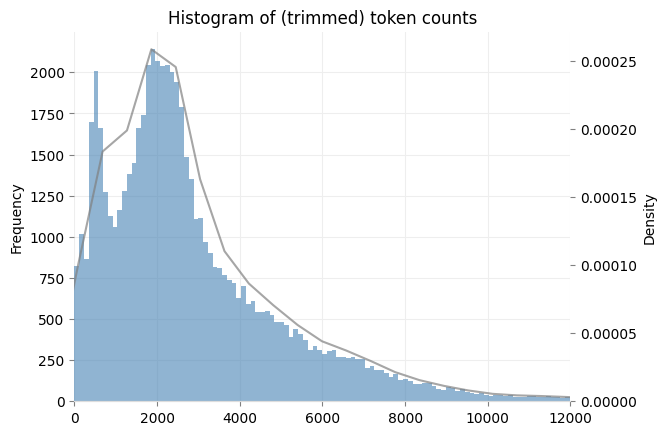

In [8]:
text_lens = [len(text) for text in data['tokens']]

def axesStyling(ax, xlims = None, ylims = None):
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_color('#DDDDDD')
        ax.tick_params(bottom=True, left=False, color = 'gray')
        ax.set_axisbelow(True)
        ax.yaxis.grid(True, color='#EEEEEE')
        ax.xaxis.grid(True, color='#EEEEEE')

        if xlims != None:
            ax.set_xlim(xlims)
        if ylims != None:
            ax.set_ylim(ylims)
        
# ------------------------------------------------------------------------
# Define function for plotting the histogram of word counts
#    this function would be further used at the LDA topic modeling section
# ------------------------------------------------------------------------
def wordcountsHist(ax, data, topic = None, xlims = [0, 15000], ylims = None,
                   color = 'steelblue', alpha = 0.8):

    # If topic is given, plot word count histogram based on topic
    try:
        text_topic = data[data['Dominant_topic'] == topic]['tokens']
        text_lens = [len(text) for text in text_topic]
        ax.set_title(f"Histogram of word counts for topic {topic}")

    # if not, plot the histogram for the whole data set
    except:
        text_lens = [len(text) for text in data['tokens']]
        ax.set_title("Histogram of (trimmed) token counts")
    
    ax.hist(text_lens, bins = 1000, color = color, alpha = alpha);
    ax.set_ylabel("Frequency")
 
    axesStyling(ax, xlims = xlims, ylims = ylims)

    ax_kde = ax.twinx()
    sns.kdeplot(text_lens, color = "gray", ax = ax_kde, alpha = 0.7, bw_adjust = 1);
    axesStyling(ax_kde, xlims = xlims, ylims = ylims)
    ax_kde.grid(False)

fig, ax = plt.subplots(1, 1)
wordcountsHist(ax, data, alpha = 0.6, xlims = [0, 12000])

Most documents have number of words at around 1000 - 3000.

### Simple Word Cloud

In [10]:
# Join all tokens to one string
strings = " ".join(data['tokens'].tolist())

In [11]:
# Fit wordcloud
begin = time.time()
wordcloud_ = WordCloud(max_font_size = 100,
                       width = 900, height = 600,
                       background_color = 'white').generate(strings)
end = time.time()
print(f"WordCloud Generated. {round(end - begin, 3)} seconds used.")

WordCloud Generated. 69.012 seconds used.


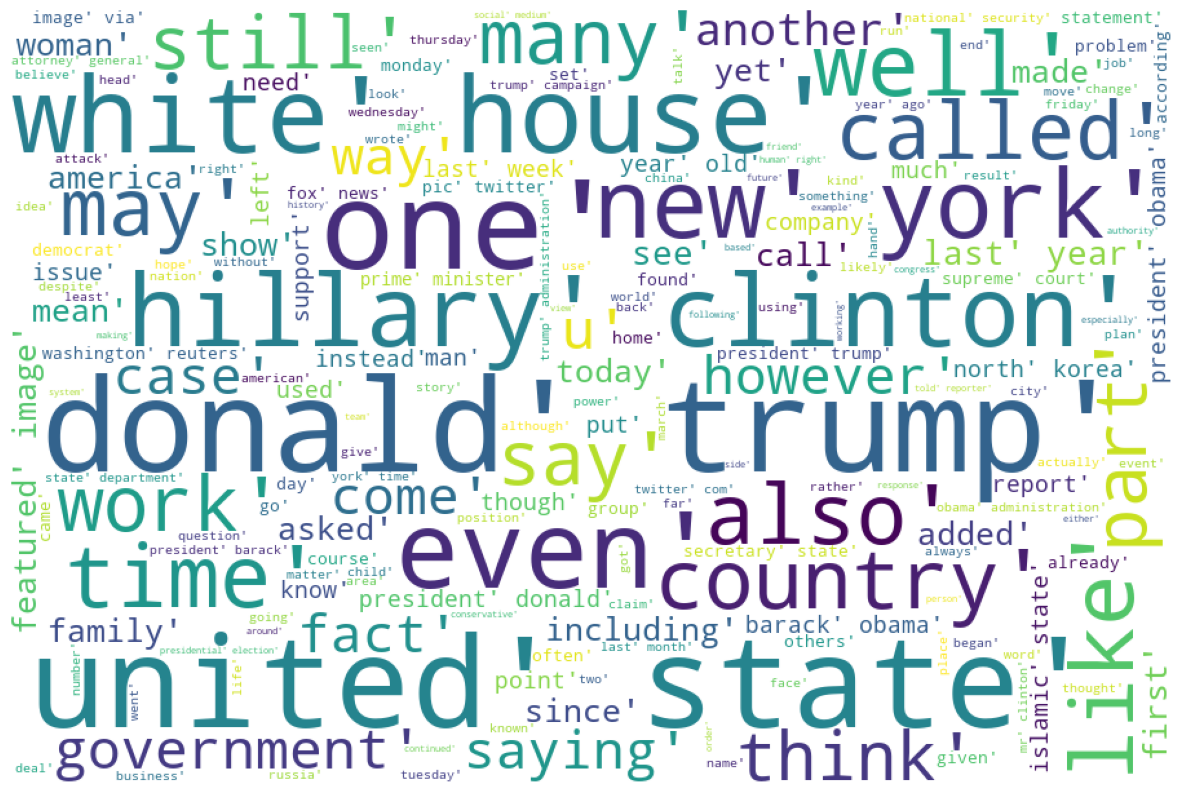

In [12]:
plt.figure(figsize = (15, 12))
plt.imshow(wordcloud_)
plt.axis('off')
plt.savefig('wordcloud.png')
plt.show()

#### Train wordcloud condition on Label

In [35]:
begin = time.time()
fake_news = " ".join(data[data['label'] == 1]['tokens'].tolist())
wc_fake = WordCloud(max_font_size = 100,
                       width = 900, height = 700,
                       background_color = 'white').generate(fake_news)
end = time.time()
print(f'WordCloud for Fake news corpus generated. {round(end - begin, 3)} seconds used.')


begin = time.time()
real_news = " ".join(data[data['label'] == 0]['tokens'].tolist())
wc_real = WordCloud(max_font_size = 100,
                       width = 900, height = 700,
                       background_color = 'white').generate(real_news)
end = time.time()
print(f'WordCloud for Real news corpus generated. {round(end - begin, 3)} seconds used.')

WordCloud for Fake news corpus generated. 30.96 seconds used.
WordCloud for Real news corpus generated. 21.547 seconds used.


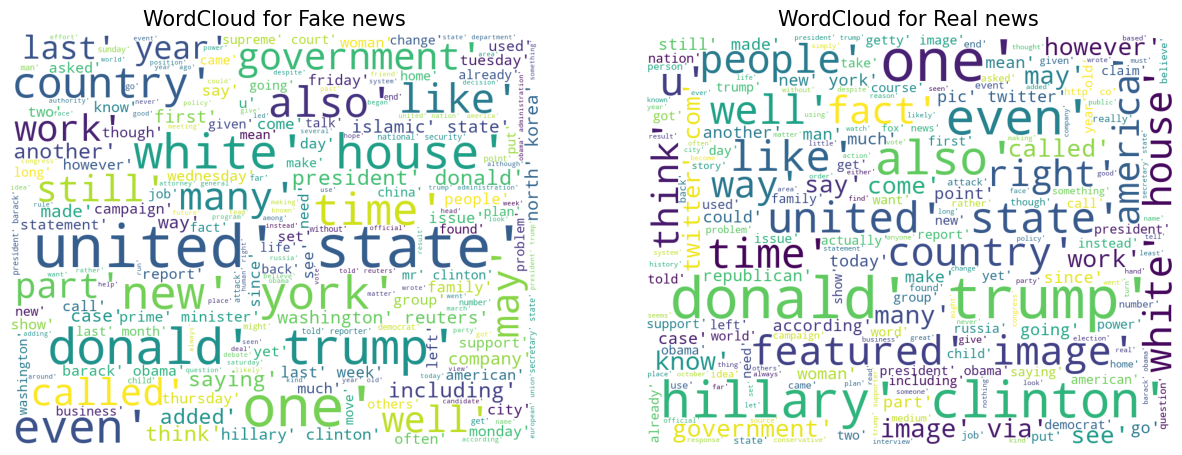

In [36]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 8))

for ax, pic, name in zip([ax1, ax2], [wc_fake, wc_real], ['Fake', 'Real']):
    ax.imshow(pic)
    ax.axis('off')
    ax.set_title(f"WordCloud for {name} news", fontsize = 15)
fig.savefig("wordcloud_conditioned_on_label.png")

According to the condition wordcloud, we can see that documents of real news have "Donald Trump" and "Hillary Clinton" both large, while documents of fake news only have "Donald Trump" large. This could suggest that pro-republicans media are prone to fake news.

Other significant trend was not observed.

### Sentiment Analysis

- Fit the `SentimentIntensityAnalyzer()` to the whole dataset

In [ ]:
########################################
# ---------- Training ------------
########################################

begin = time.time()
sia = SentimentIntensityAnalyzer()
emotion_scores = data['text'].apply(sia.polarity_scores)

end = time.time()
print(f"Sentiment Score for each news obtained. {round(end - begin, 3)} seconds used.")

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/huanglinchun/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Sentiment Score for each news obtained. 193.762 seconds used.


In [ ]:
data['negative'] = emotion_scores.apply(lambda x: x['neg'])
data['neutral'] = emotion_scores.apply(lambda x: x['neu'])
data['positive'] = emotion_scores.apply(lambda x: x['pos'])
data['compound'] = emotion_scores.apply(lambda x: x['compound'])
data.to_csv("final_tokenized_sentiment.csv")

In [15]:
########################################
# ---------- Loading ------------
########################################

data = pd.read_csv('final_tokenized_sentiment.csv').drop('Unnamed: 0', axis = 1)
data.head(5)

,title,text,label,tokens,negative,neutral,positive,compound
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,0,"['comment', 'expected', 'barack', 'obama', 'me...",0.117,0.799,0.085,-0.9928
1,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",0,"['demonstrator', 'gathered', 'last', 'night', ...",0.051,0.740,0.209,0.7351
2,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,1,"['dozen', 'politically', 'active', 'pastor', '...",0.028,0.839,0.133,0.9993
3,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",0,"['r', 'sarmat', 'missile', 'dubbed', 'satan', ...",0.081,0.869,0.051,-0.9081
4,About Time! Christian Group Sues Amazon and SP...,All we can say on this one is it s about time ...,0,"['one', 'time', 'someone', 'sued', 'southern',...",0.160,0.724,0.116,-0.9255


- Visualize the empirical distribution of four sentiment indexes. 

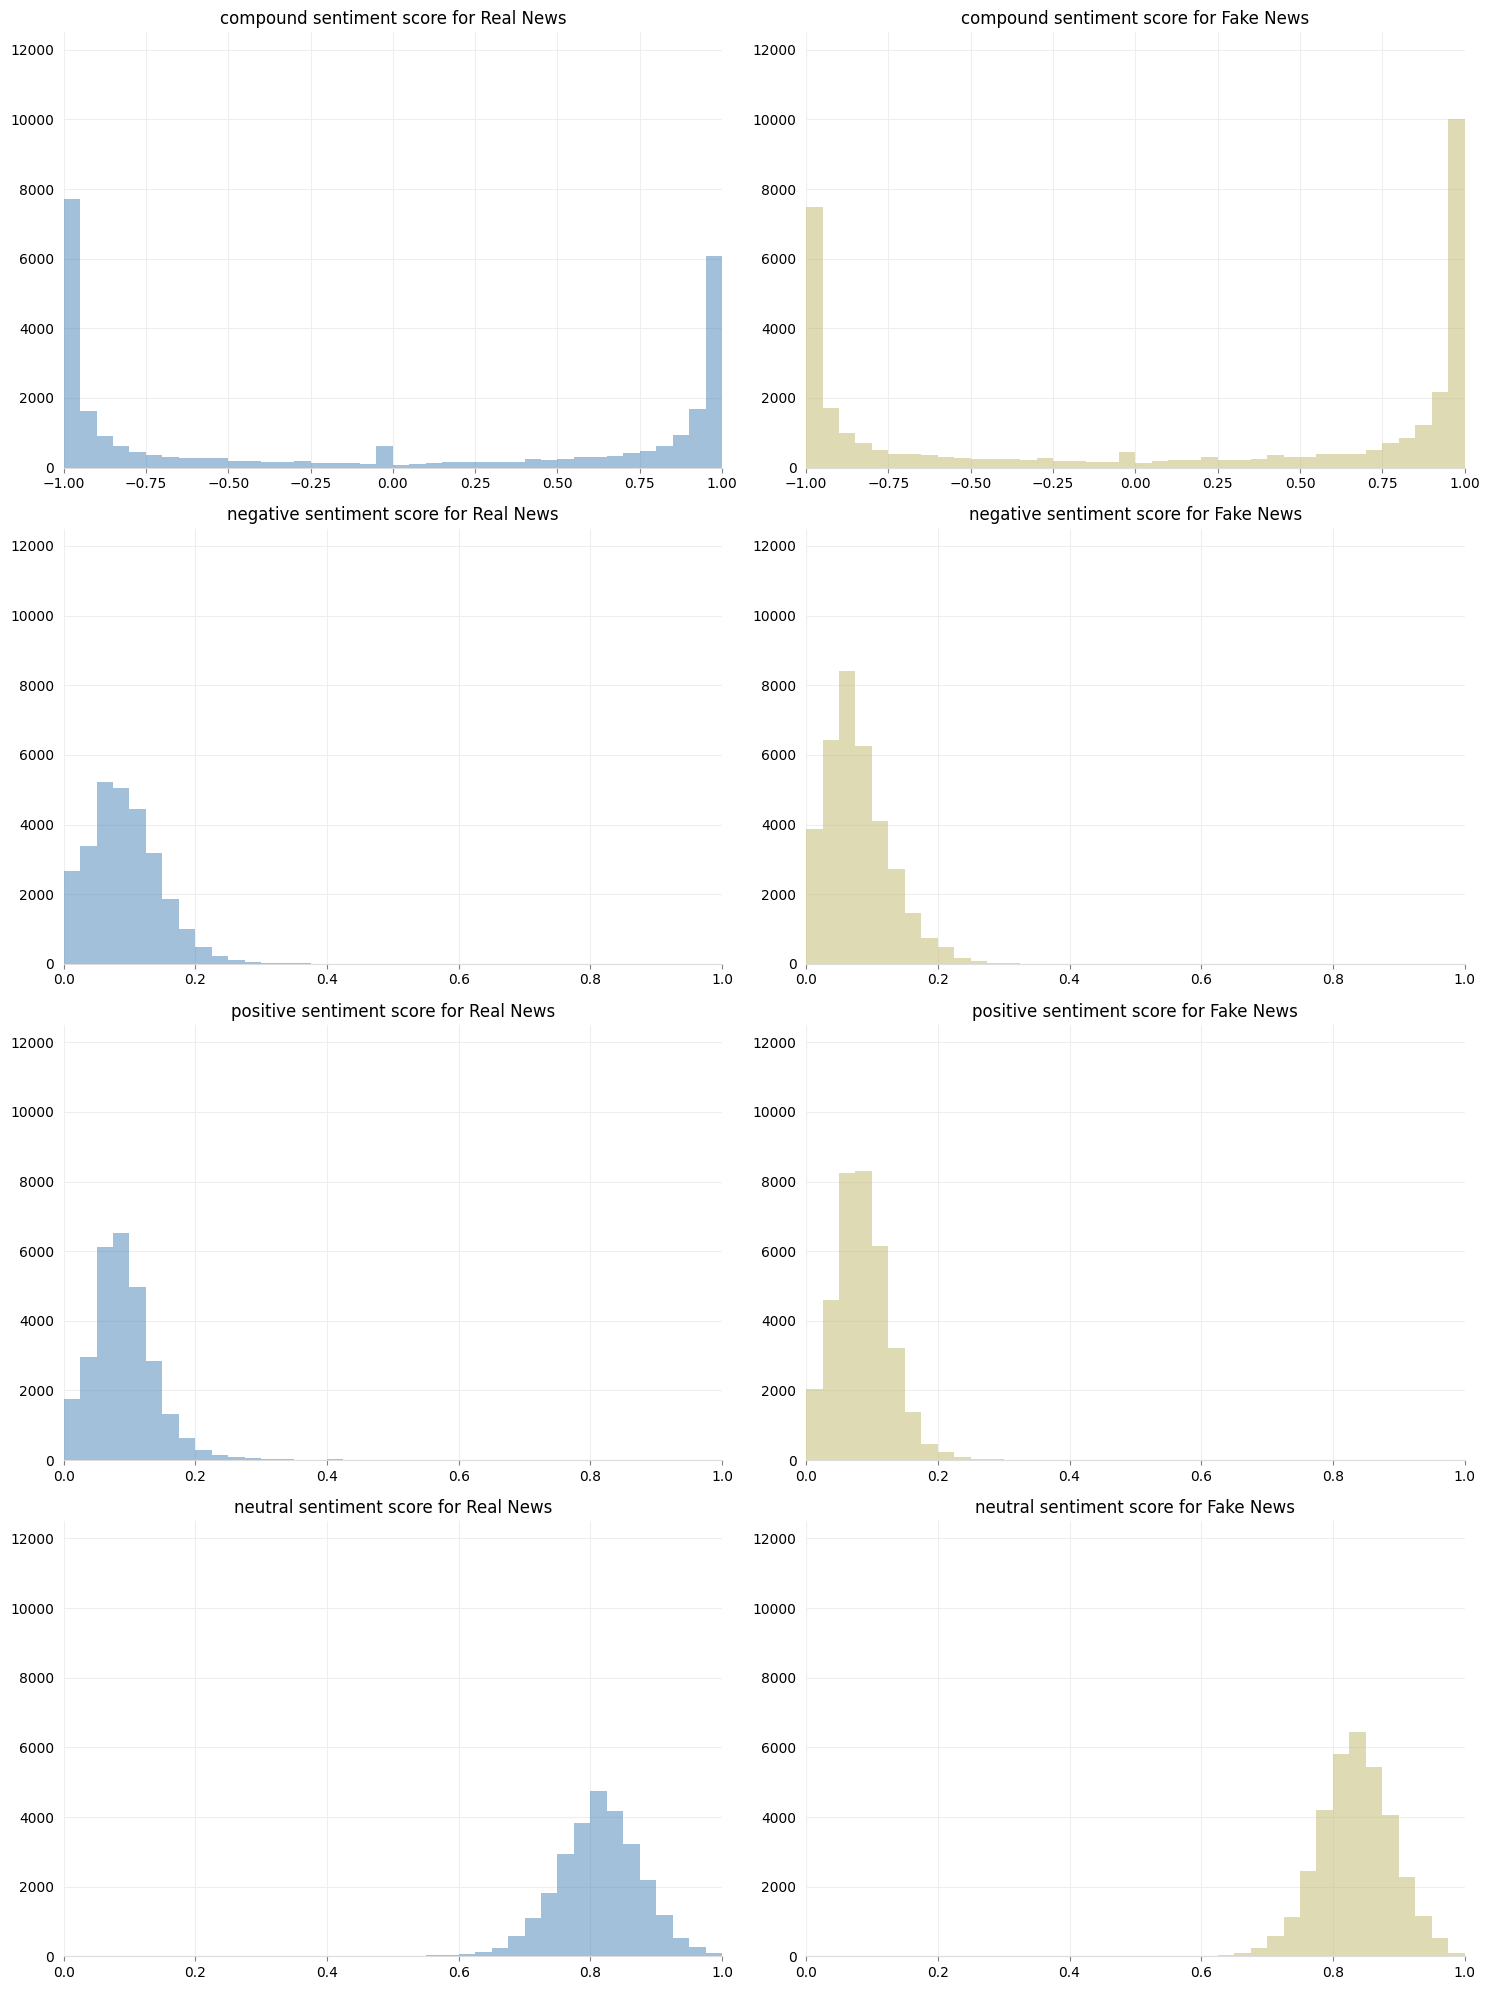

In [17]:
xlims_dict = {'negative': [0, 1], 'positive': [0, 1], 'neutral': [0, 1], 
              'compound': [-1, 1]}
bins_ = [b for b in np.arange(0, 1.05, 0.025)]
bins_dict = {'negative': bins_, 'neutral': bins_, 'positive': bins_, 
             'compound': [b for b in np.arange(-1, 1.05, 0.05)]}

def sentimentPlot(ax1, ax2, score, xlims, bins_):

    # Real news
    ax1.hist(data[data['label'] == 0][score], 
             bins = bins_, alpha = 0.5, color = 'steelblue')
    # Fake news
    ax2.hist(data[data['label'] == 1][score], 
             bins = bins_, alpha = 0.5, color = 'darkkhaki')

    # Axes styling <- pre-defined function
    axesStyling(ax1, xlims = xlims, ylims = [0,12500])
    axesStyling(ax2, xlims = xlims, ylims = [0,12500])

    # Set title
    ax1.set_title(f"{score} sentiment score for Real News", fontsize = 12)
    ax2.set_title(f"{score} sentiment score for Fake News", fontsize = 12)

fig, tups = plt.subplots(4, 2, figsize = (15, 20))
for score, tup in zip(['compound', 'negative', 'positive', 'neutral'], tups):
    sentimentPlot(tup[0], tup[1], score, xlims_dict[score], bins_dict[score])

fig.tight_layout()

According to the graph above, there exists no significant distributive difference in all four sentiments score between real and fake news. It might be difficult to distinguish fake news from real news based on only sentiment indexes.

#### Word Count, Sentiment, and Truthfulness

We analyzed the interaction between word (token) counts and each sentiment scores, trying to figure out if these two features seperate fake and real news well.

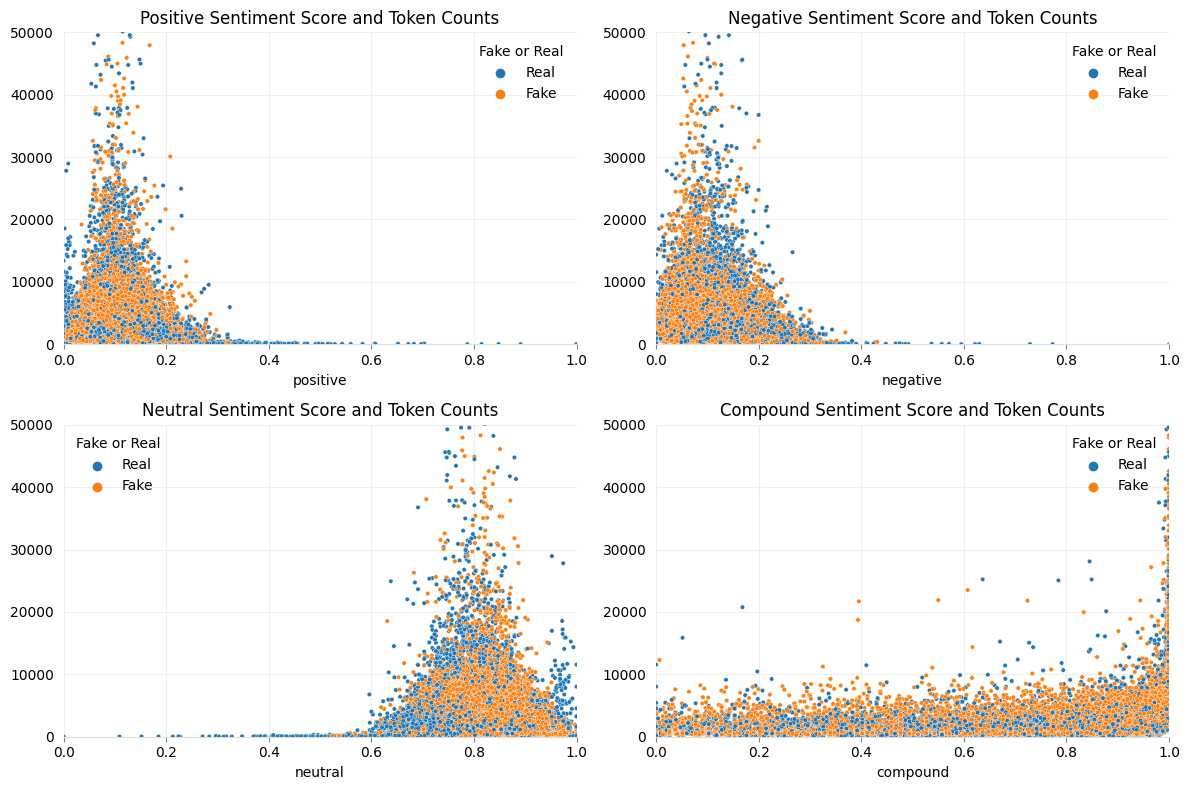

In [18]:
fig, axes = plt.subplots(2, 2, figsize = (12, 8))
sent_list = ['positive', 'negative', 'neutral', 'compound']

for ax, sentiment in zip(axes.flatten(), sent_list):
    graph = sns.scatterplot(x = data[sentiment], 
                    y = data['tokens'].apply(len).tolist(),
                    hue = data['label'], s = 10, ax = ax);
    axesStyling(ax, xlims = [0, 1], ylims = [0, 50000])
    ax.legend(frameon = False)
    ax.set_title(f"{sentiment.title()} Sentiment Score and Token Counts")

    graph.get_legend().set_title("Fake or Real")
    graph.get_legend().texts[0].set_text("Real")
    graph.get_legend().texts[1].set_text("Fake")

fig.tight_layout()


Based on the graph above, longer texts tend to have more neutral tone, less positive tone, and less negative tone. However, there is no observable correlation between word counts and compound sentiment index. 

In addition, these two features seem not to separate the real and fake news well.

### Topic Modeling - LDA

- Transform the list-like string format tokens into real list-type data by `ast` module

In [23]:
# We have to transform the string presentation of lists to "list"
begin = time.time()
data['tokens'] = data['tokens'].apply(ast.literal_eval)
end = time.time()
print(f'List transformation finished. {round(end - begin, 3)} seconds used')

List transformation finished. 18.949 seconds used


- Generate a bag of word (corpus) from the union of tokens.

In [38]:
begin = time.time()

bag_of_word = corpora.Dictionary(data['tokens'])
corpus = [bag_of_word.doc2bow(text) for text in data['tokens']]

end = time.time()
print(f'Corpos built. {round(end - begin, 3)} seconds used')

Corpos built. 15.322 seconds used


In [39]:
pickle.dump(corpus, open('corpus.pkl', 'wb'))
bag_of_word.save('dictionary.gensim')

- Train the LDA Topic model

We set the number of clusters (topics) as 10.

In [40]:
########################################
# ---------- Training ------------
########################################

# LDA topic model training (10)
begin = time.time()

num_topics = 10
ldamodel = gensim.models.ldamodel.LdaModel(corpus, 
                                           num_topics = num_topics, 
                                           id2word =bag_of_word, 
                                           passes=15,
                                           random_state = 000)
ldamodel.save('model10.gensim')

end = time.time()
print(f'LDA Topic Model trained. {round(end - begin, 3)} seconds used.')

LDA Topic Model trained. 590.954 seconds used.


Three datasets (model) were exported for further use.
1. dictionary.gensim (bag_of_word)
2. corpus.pkl
3. model10.gensim (ldamodel)

In [24]:
########################################
# ---------- Loading ------------
########################################
ldamodel = gensim.models.ldamodel.LdaModel.load("model10.gensim")
lda_dict = corpora.Dictionary.load('dictionary.gensim')
corpus = [lda_dict.doc2bow(doc) for doc in data['tokens']]

- Print the keywords and weights in all topics

In [33]:
topics = ldamodel.print_topics(num_words=10)
for topic in topics:
    print(topic)

(0, '0.047*"clinton" + 0.022*"election" + 0.021*"hillary" + 0.018*"party" + 0.014*"campaign" + 0.014*"state" + 0.014*"voter" + 0.014*"vote" + 0.012*"candidate" + 0.010*"republican"')
(1, '0.009*"investigation" + 0.009*"email" + 0.008*"official" + 0.008*"fbi" + 0.007*"russia" + 0.007*"russian" + 0.007*"department" + 0.007*"intelligence" + 0.007*"information" + 0.007*"news"')
(2, '0.077*"trump" + 0.019*"president" + 0.014*"donald" + 0.013*"republican" + 0.010*"obama" + 0.008*"white" + 0.007*"house" + 0.006*"twitter" + 0.006*"campaign" + 0.005*"news"')
(3, '0.015*"police" + 0.009*"city" + 0.007*"people" + 0.006*"officer" + 0.006*"year" + 0.006*"gun" + 0.006*"two" + 0.006*"one" + 0.005*"family" + 0.004*"told"')
(4, '0.012*"state" + 0.008*"government" + 0.007*"united" + 0.007*"military" + 0.007*"country" + 0.006*"war" + 0.006*"russia" + 0.005*"minister" + 0.005*"president" + 0.005*"reuters"')
(5, '0.011*"tax" + 0.009*"year" + 0.007*"republican" + 0.007*"bill" + 0.007*"state" + 0.007*"house"

#### 1. What is the dominant topic and its percentage contribution in each document

Each document has a probability vector of belonging to specific topics. We labeled a document as topic `k` when the probability of topic `k` is the highest among all other topics.

In [34]:
########################################
# ---------- Processing ------------
########################################
# Remember to pass in the data with sentiment score!
def format_topic_sentences(texts, ldamodel = None, corpus = corpus):

    # Empty DF
    topics_df = pd.DataFrame()

    # Get main topic in each document
    loop_10000 = ['first', 'second', 'third', 'fourth', 'fifth', 'sixth', 'seventh', 'eighth']
    loop = 0
    for i, row_list in enumerate(ldamodel[corpus]):
        row = sorted(row_list, key = lambda x: x[1], reverse = True)
        
        # Put main topic and the proportion into the dataframe
        dominant_topic = row[0][0]
        dominant_prop = row[0][1]
        keywords_dominant = ", ".join([word for word, prop in ldamodel.show_topic(dominant_topic)])
        
        topics_df.loc[i, ['topic', 'proportion', 'keywords']] = [int(dominant_topic), round(dominant_prop,4), keywords_dominant]

        if (i % 10000 == 0) and (i != 0):
            print(f"{loop_10000[loop]} 10000 documents were processed.")
            loop += 1

    print("All documents processed.")
    df_merged = pd.concat([topics_df, data], ignore_index=True, sort=False, axis = 1)
    df_merged.columns = ['Dominant_topic', 'Contribution%', 'key_words', 'title', 'text',
                         'label', 'tokens', 'negative', 'neutral', 'positive', 'compound']

    return df_merged

lda_result = format_topic_sentences(data, ldamodel, corpus)

first 10000 documents were processed.
second 10000 documents were processed.
third 10000 documents were processed.
fourth 10000 documents were processed.
fifth 10000 documents were processed.
sixth 10000 documents were processed.
All documents processed.


In [35]:
lda_result.dropna(how = 'any', inplace = True)

In [38]:
lda_result.to_csv("lda_result_df.csv")

In [9]:
########################################
# ---------- Loading ------------
########################################
lda_result = pd.read_csv('lda_result_df.csv').drop('Unnamed: 0', axis = 1)
lda_result

,Dominant_topic,Contribution%,key_words,title,text,label,tokens,negative,neutral,positive,compound
0,9,0.5646,"people, one, like, time, u, even, year, know, ...",LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,0,"['comment', 'expected', 'barack', 'obama', 'me...",0.117,0.799,0.085,-0.9928
1,7,0.4513,"state, court, law, right, government, judge, j...",UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",0,"['demonstrator', 'gathered', 'last', 'night', ...",0.051,0.740,0.209,0.7351
2,9,0.4542,"people, one, like, time, u, even, year, know, ...","Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,1,"['dozen', 'politically', 'active', 'pastor', '...",0.028,0.839,0.133,0.9993
3,6,0.3463,"china, north, de, korea, la, chinese, n, nucle...",SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",0,"['r', 'sarmat', 'missile', 'dubbed', 'satan', ...",0.081,0.869,0.051,-0.9081
4,7,0.4753,"state, court, law, right, government, judge, j...",About Time! Christian Group Sues Amazon and SP...,All we can say on this one is it s about time ...,0,"['one', 'time', 'someone', 'sued', 'southern',...",0.160,0.724,0.116,-0.9255
...,...,...,...,...,...,...,...,...,...,...,...
62591,0,0.4838,"clinton, election, hillary, party, campaign, s...",WIKILEAKS EMAIL SHOWS CLINTON FOUNDATION FUNDS...,An email released by WikiLeaks on Sunday appea...,0,"['email', 'released', 'wikileaks', 'sunday', '...",0.070,0.879,0.052,-0.4261
62592,1,0.6757,"investigation, email, official, fbi, russia, r...",Russians steal research on Trump in hack of U....,WASHINGTON (Reuters) - Hackers believed to be ...,1,"['washington', 'reuters', 'hacker', 'believed'...",0.059,0.865,0.076,0.9355
62593,2,0.7193,"trump, president, donald, republican, obama, w...",WATCH: Giuliani Demands That Democrats Apolog...,"You know, because in fantasyland Republicans n...",0,"['know', 'fantasyland', 'republican', 'never',...",0.147,0.784,0.069,-0.9959
62594,4,0.6606,"state, government, united, military, country, ...",Migrants Refuse To Leave Train At Refugee Camp...,Migrants Refuse To Leave Train At Refugee Camp...,1,"['migrant', 'refuse', 'leave', 'train', 'refug...",0.076,0.831,0.093,0.7748


#### 2. Frequency Distribution of Word Counts in Documents condition on Dominant Topic

In [17]:
for i in range(0, 10):
    print("Topic " + str(i) + ": " + str(len(lda_result[lda_result['Dominant_topic'] == i])) + " counts")

Topic 0: 3312 counts
Topic 1: 5102 counts
Topic 2: 10576 counts
Topic 3: 4598 counts
Topic 4: 10610 counts
Topic 5: 6196 counts
Topic 6: 1391 counts
Topic 7: 4047 counts
Topic 8: 2990 counts
Topic 9: 13774 counts


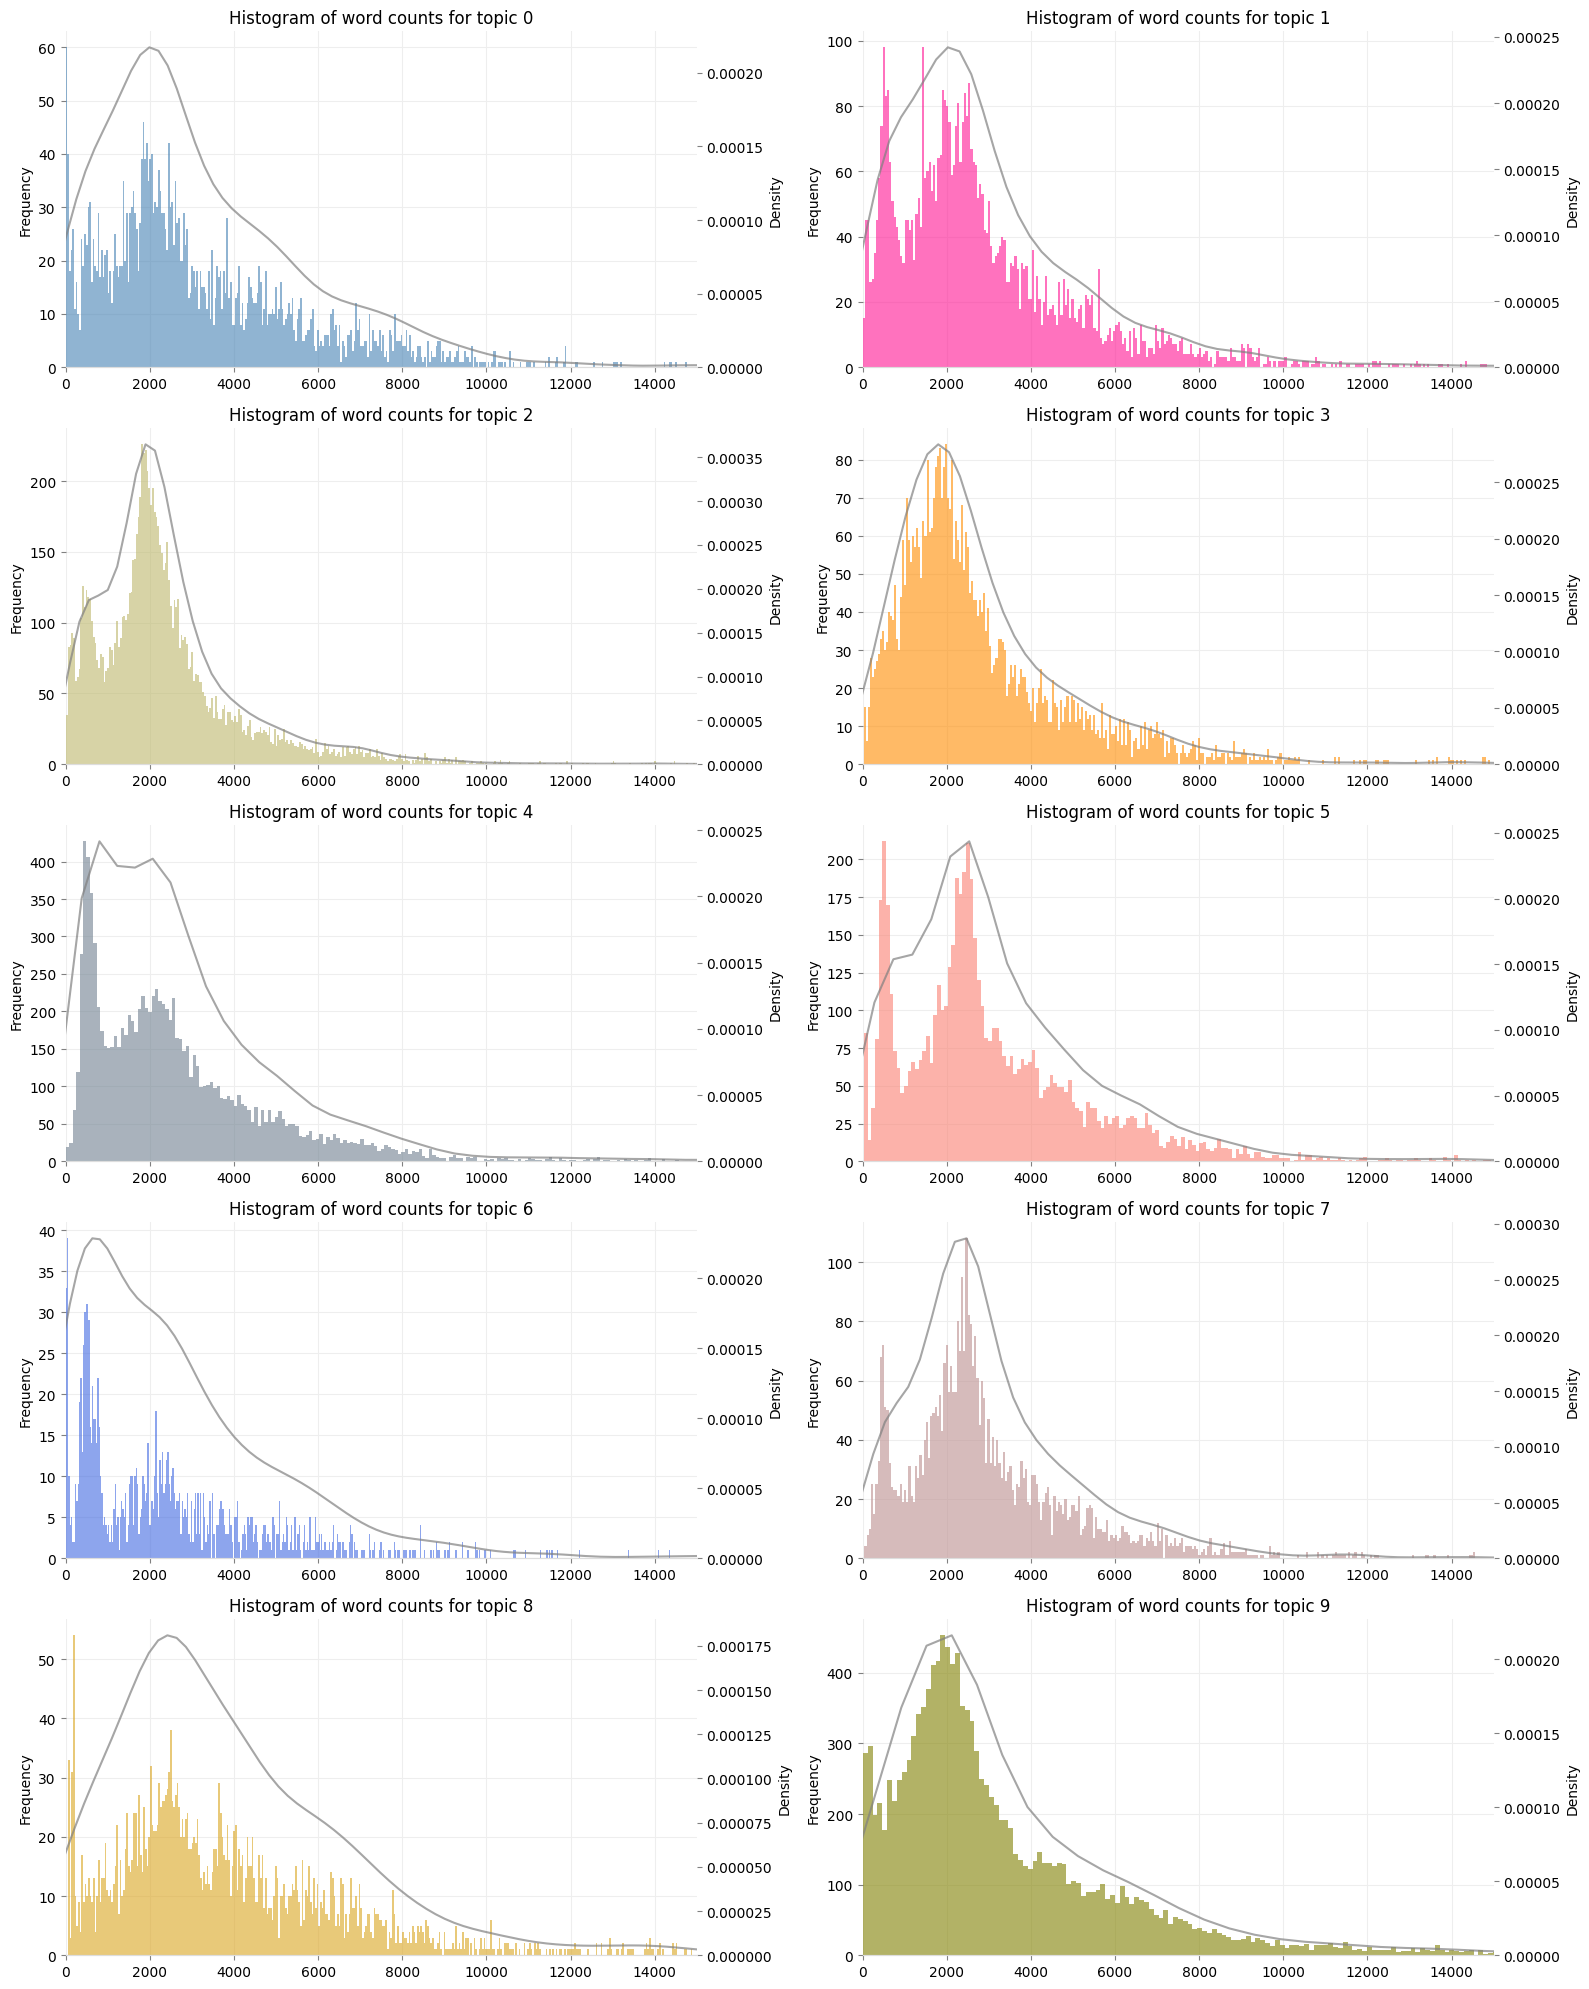

In [20]:
# Plot the frequency distribution of word counts for 10 topics

fig, axes = plt.subplots(5, 2, figsize = (16, 20))

colors = ['steelblue', 'deeppink', 'darkkhaki', 'darkorange', 'slategrey', 
          'salmon', 'royalblue', 'rosybrown', 'goldenrod', 'olive']
for i, ax, color in zip([j for j in range(0, 10)], axes.flatten(), colors):
    wordcountsHist(ax, lda_result, topic = i, alpha = 0.6, color = color, ylims = None);
fig.tight_layout()

#### 3.  Identify Topics by Word Cloud

It seems that the contioned word count distributions did not provide valuable insights.

We further analyze each topics based on topic-specifi word clouds, and then identify each topics based on the existing knowledge.

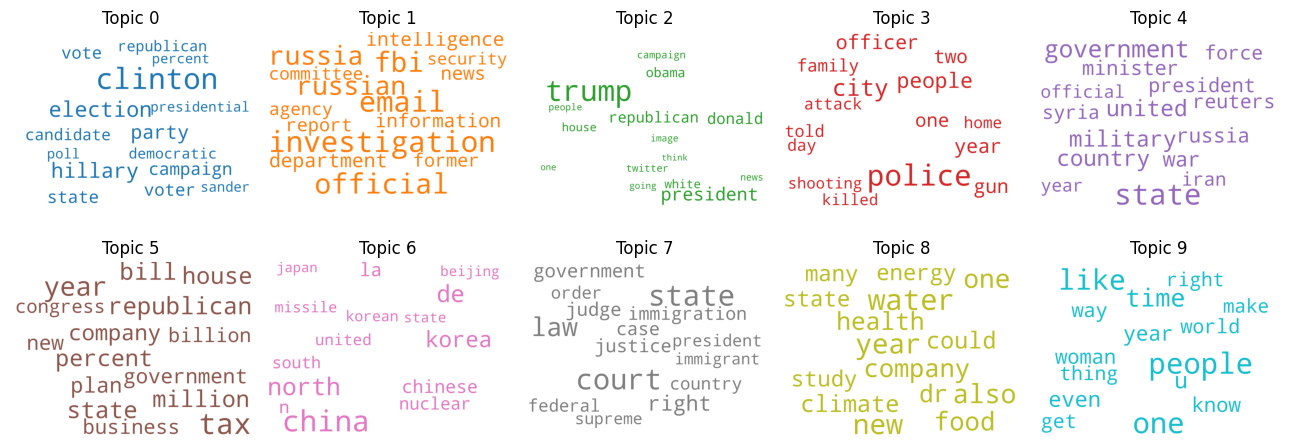

In [25]:


stop_words = stopwords.words('english')
colors = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=20,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: colors[i],
                  prefer_horizontal=1.0)

topics = ldamodel.show_topics(formatted=False, num_words = 15)

fig, axes = plt.subplots(2, 5, figsize=(13,5), sharex=True, sharey=True)
for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=12))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

Identify the clustered topic by human interpretation.

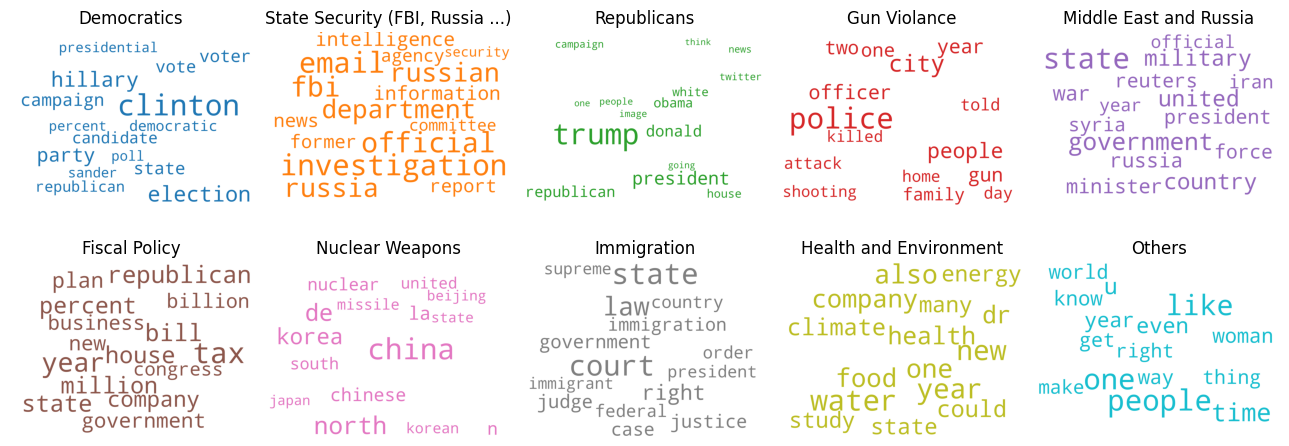

In [ ]:
cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=20,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: colors[i],
                  prefer_horizontal=1.0)

topics = ldamodel.show_topics(formatted=False, num_words = 15)

fig, axes = plt.subplots(2, 5, figsize=(13,5), sharex=True, sharey=True)

topics_interpret = ["Democratics", "State Security (FBI, Russia ...)", "Republicans",
                    "Gun Violance", "Middle East and Russia",
                    "Fiscal Policy", "Nuclear Weapons", "Immigration",
                    "Health and Environment", "Others"]

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title(topics_interpret[i], fontdict=dict(size=12))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

#### 4. Check the topic distribution contioned on target (fake news or not)

In [47]:
topic_dist = lda_result.groupby(['label', 'Dominant_topic']).agg({'Dominant_topic': "count"})
topic_dist.columns = ["Count"]

topic_dist_real = topic_dist.loc[0]
topic_dist_real['proportion'] = round(topic_dist_real["Count"]/(topic_dist_real["Count"].sum()), 3)
topic_dist_fake = topic_dist.loc[1]
topic_dist_fake['proportion'] = round(topic_dist_fake["Count"]/(topic_dist_fake["Count"].sum()), 3)
topic_dist = pd.concat([topic_dist_real, topic_dist_fake], axis = 1)
topic_dist.columns = ['# real', 'Real', '# fake', 'Fake']
topic_dist.index = topics_interpret
topic_dist

,# real,Real,# fake,Fake
Democratics,1485,0.053,1827,0.053
"State Security (FBI, Russia ...)",2256,0.081,2846,0.082
Republicans,6573,0.236,4003,0.115
Gun Violance,2098,0.075,2500,0.072
Middle East and Russia,1866,0.067,8744,0.251
Fiscal Policy,1228,0.044,4968,0.143
Nuclear Weapons,416,0.015,975,0.028
Immigration,874,0.031,3173,0.091
Health and Environment,1346,0.048,1644,0.047
Others,9664,0.348,4110,0.118


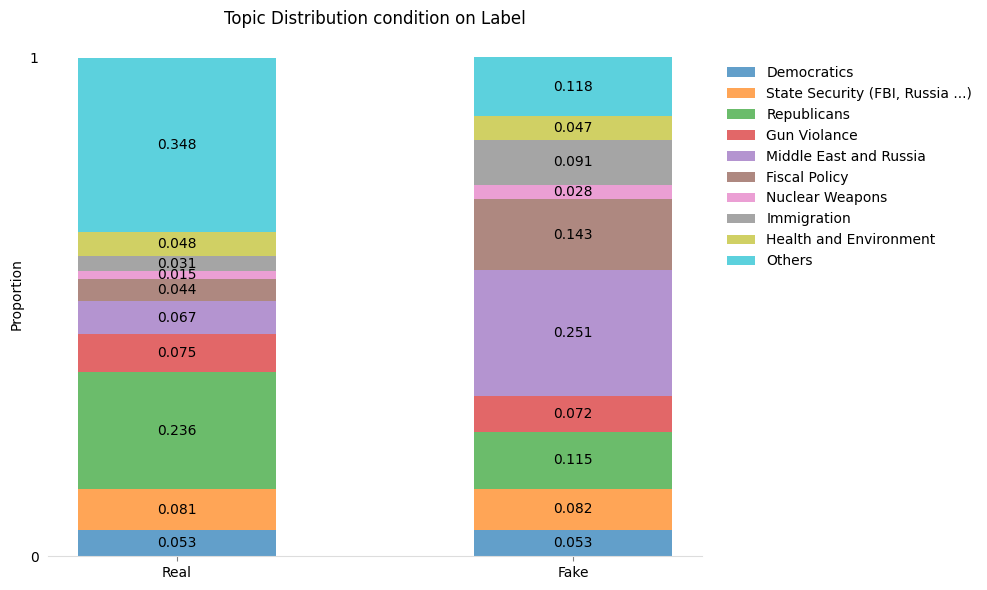

In [56]:
topic_plot = round(topic_dist[['Real', 'Fake']], 3)

fig, ax = plt.subplots(1, 1, figsize = (10, 6))

for i in range(len(topic_plot)):
    c = ax.bar(x = topic_plot.columns,
          height = topic_plot.iloc[i],
          bottom = topic_plot.iloc[:i].sum(),
          width=.5,
          alpha=.7,
          label = topic_plot.index[i])
    ax.bar_label(c, label_type='center')
      
ax.set_yticks([0, 1])
ax.set_ylabel("Proportion")
ax.set_title("Topic Distribution condition on Label")
ax.legend(loc = 2, bbox_to_anchor=(1.02, 0.96), frameon = False)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#DDDDDD')
ax.tick_params(bottom=True, left=False, color = 'gray')
ax.set_axisbelow(True)
ax.yaxis.grid(False)
ax.xaxis.grid(False)

fig.tight_layout()

Based on the stacked bar plot above, we observed that among real news, topic "Republicans" is prevalent, which is surprising. In addition, real news also have higher proportion of other news, which might indicate that real news are more diversified.

On the other hand, among fake news, topic "Middle East and Russia" is prominently high, which might indicate that the U.S. is prone to international fake news attack. 